In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.models import load_model
from joblib import load
import joblib

# En este documento se predecirán nuevas gráficas con valores de fracción volumen, radio y espesor de la partícula nuevos

Carga del modelo normalizado

In [2]:
model = tf.keras.models.load_model('h5/EXPERIMENT.h5')

# Especificando los valores a usar

In [3]:
fracvol =  1
radio = 20
espesor = 200
longitud_de_onda = list(range(301, 901))

Creando diccionario

In [4]:
data = {
    "Longitud de onda": longitud_de_onda,
    "Fracvol": [fracvol] * len(longitud_de_onda),
    "Radio (nm)": [radio] * len(longitud_de_onda),
    "Espesor de la película (nm)": [espesor] * len(longitud_de_onda)
}

Creando DF

In [5]:
df  = pd.DataFrame(data)
df

,Longitud de onda,Fracvol,Radio (nm),Espesor de la película (nm)
0,301,1,20,200
1,302,1,20,200
2,303,1,20,200
3,304,1,20,200
4,305,1,20,200
...,...,...,...,...
595,896,1,20,200
596,897,1,20,200
597,898,1,20,200
598,899,1,20,200


Normalizando valores

In [6]:
scaler_X = joblib.load('minmax_scaler_X.pkl')
x = df.values
x_norm = scaler_X.transform(x)

# Predicciones

In [7]:
predictions = model.predict(x_norm)

19/19 [==============================] - 0s 781us/step


In [8]:
df1 = pd.DataFrame(df, columns = ['Longitud de onda', 'Fracvol', 'Radio (nm)', 'Espesor de la película (nm)'])
df2 = pd.DataFrame(predictions , columns = ['Índice de absorción'])

In [9]:
result_df = pd.concat([df1, df2], axis=1)
result_df

,Longitud de onda,Fracvol,Radio (nm),Espesor de la película (nm),Índice de absorción
0,301,1,20,200,0.016848
1,302,1,20,200,0.016568
2,303,1,20,200,0.016288
3,304,1,20,200,0.016009
4,305,1,20,200,0.015729
...,...,...,...,...,...
595,896,1,20,200,0.000889
596,897,1,20,200,0.000898
597,898,1,20,200,0.000907
598,899,1,20,200,0.000916


# Gráfica con valores normalizados

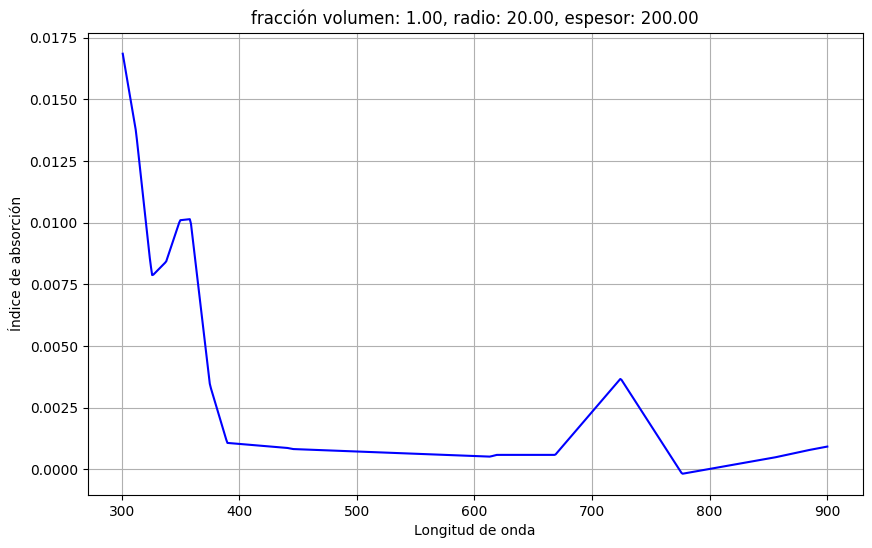

In [10]:
columnas_seleccionadas = ['Longitud de onda', 'Índice de absorción']
df_seleccionado = result_df[columnas_seleccionadas]
titulo = 'fracción volumen: {:.2f}, radio: {:.2f}, espesor: {:.2f}'.format(fracvol, radio, espesor)

# Crear la gráfica de dispersión
plt.figure(figsize=(10, 6))
plt.plot(df_seleccionado['Longitud de onda'], df_seleccionado['Índice de absorción'], color='blue')
plt.xlabel('Longitud de onda')
plt.ylabel('Índice de absorción')
plt.title(titulo)
plt.grid(True)
plt.show()

# Haciendolo con varias gráficas a la vez

Funcion que genera y guarda imagenes generadas

In [11]:
files = [file for file in os.listdir('./parametros')]

param = pd.DataFrame()
for file in files:
  df = pd.read_csv('./parametros/'+file)
  param = pd.concat([param, df], axis= 0)

In [12]:
combinaciones_unicas = param[['Fracvol', 'Radio (nm)', 'Espesor de la película (nm)']].drop_duplicates().reset_index(drop=True)
combinaciones_filtradas = combinaciones_unicas[combinaciones_unicas['Fracvol'] <= 3].reset_index(drop=True)

In [13]:
fracvol = combinaciones_filtradas['Fracvol'].tolist()
radio = combinaciones_filtradas['Radio (nm)'].tolist()
espesor = combinaciones_filtradas['Espesor de la película (nm)'].tolist()
longitud_de_onda = list(range(301, 901))

In [14]:
# Asegurarse de que la carpeta graficas_reales exista
if not os.path.exists('graficas_reales'):
    os.makedirs('graficas_reales')

# Iterar sobre las combinaciones únicas y filtradas
for f, r, e in zip(fracvol, radio, espesor):
    # Filtrar el dataframe params para obtener datos que coincidan con la combinación actual
    subset = param[(param['Fracvol'] == f) & 
                    (param['Radio (nm)'] == r) & 
                    (param['Espesor de la película (nm)'] == e)]
    
    # Si hay menos de 600 datos para esta combinación, saltar a la siguiente iteración
    if len(subset) < 600:
        continue

    # Crear la gráfica de dispersión para esta combinación
    plt.figure(figsize=(10, 6))
    plt.plot(subset['Longitud de onda'], subset['Índice de absorción'], color='blue')
    plt.xlabel('Longitud de onda')
    plt.ylabel('Índice de absorción')
    titulo = 'fracción volumen: {:.2f}, radio: {:.2f}, espesor: {:.2f}'.format(f, r, e)
    plt.title(titulo)
    plt.grid(True)
    filename = 'graficas_reales/grafica_{:.2f}_{:.2f}_{:.2f}.png'.format(f, r, e)
    plt.savefig(filename)
    plt.close()




In [15]:
# Asegurar que la carpeta existe o crearla
carpeta = "graficas_predichas"
if not os.path.exists(carpeta):
    os.mkdir(carpeta)

# Asumiendo que todos los arrays (fracvol, radio, espesor) tienen la misma longitud:
num_elementos = len(fracvol)

scaler_X = load('minmax_scaler_X.pkl')

for i in range(num_elementos):
    data = {
        "Longitud de onda": longitud_de_onda,
        "Fracvol": [fracvol[i]] * len(longitud_de_onda),
        "Radio (nm)": [radio[i]] * len(longitud_de_onda),
        "Espesor de la película (nm)": [espesor[i]] * len(longitud_de_onda)
    }
    
    df = pd.DataFrame(data)
    x = df.values
    x_norm = scaler_X.transform(x)
    predictions = model.predict(x_norm)

    df["Índice de absorción"] = predictions

    columnas_seleccionadas = ['Longitud de onda', 'Índice de absorción']
    df_seleccionado = df[columnas_seleccionadas]
    titulo = 'fracción volumen: {:.2f}, radio: {:.2f}, espesor: {:.2f}'.format(fracvol[i], radio[i], espesor[i])

    # Crear la gráfica de dispersión
    plt.figure(figsize=(10, 6))
    plt.plot(df_seleccionado['Longitud de onda'], df_seleccionado['Índice de absorción'], color='blue')
    plt.xlabel('Longitud de onda')
    plt.ylabel('Índice de absorción')
    plt.title(titulo)
    plt.grid(True)
    
    # Guardar la gráfica como imagen en la carpeta especificada
    nombre_archivo = os.path.join(carpeta, "grafica_{}_{}_{}.png".format(fracvol[i], radio[i], espesor[i]))
    plt.savefig(nombre_archivo)
    plt.close()

19/19 [==============================] - 0s 515us/step


In [16]:
longitud_de_onda = list(range(300, 900))

In [17]:
len(longitud_de_onda)

600

In [18]:
# Crear un directorio para las gráficas si no existe
if not os.path.exists('comparacion_de_datos'):
    os.makedirs('comparacion_de_datos')

# Iteramos sobre todas las combinaciones posibles de fracvol, radio y espesor
for f, r, e in zip(fracvol, radio, espesor):
    
    # Filtrar el dataframe `param` para obtener los datos reales asociados con esa combinación
    subset = param[(param['Fracvol'] == f) & 
                   (param['Radio (nm)'] == r) & 
                   (param['Espesor de la película (nm)'] == e)]
    
    # Si hay menos de 600 datos o más de 600, saltamos a la siguiente iteración
    if len(subset) != 600:
        continue

    # Extraer la 'Longitud de onda' y el 'Índice de absorción'
    X_real = subset[['Longitud de onda', 'Fracvol', 'Radio (nm)', 'Espesor de la película (nm)']].values
    y_real = subset['Índice de absorción'].values

    # Hacer las predicciones con el modelo
    y_pred = model.predict(scaler_X.transform(X_real))

    # Calcular el MAE
    mae = mean_absolute_error(y_real, y_pred)
    print(f"Combinación - Fracvol: {f}, Radio: {r} nm, Espesor: {e} nm. MAE: {mae:.4f}")
    # Guardar la figura en la carpeta "comparacion_de_datos"
    # Graficar las curvas reales y predichas
    plt.figure(figsize=(10, 6))
    plt.plot(longitud_de_onda, y_real, label='Real', color='blue')
    plt.plot(longitud_de_onda, y_pred, label='Predicción', color='red', linestyle='--')
    plt.xlabel('Longitud de onda')
    plt.ylabel('Índice de absorción')
    plt.title(f'Real vs Predicha - Fracvol: {f}, Radio: {r} nm, Espesor: {e} nm')
    plt.legend()
    filename = f"Comparacion_Fracvol_{f}_Radio_{r}nm_Espesor_{e}nm.png"
    plt.savefig(os.path.join('comparacion_de_datos', filename))
    plt.close()  # Cerrar la figura actual para no llenar la memoria
    plt.show()


19/19 [==============================] - 0s 592us/step
Combinación - Fracvol: 1.0, Radio: 10.0 nm, Espesor: 100.0 nm. MAE: 0.0009
19/19 [==============================] - 0s 556us/step
Combinación - Fracvol: 1.0, Radio: 10.0 nm, Espesor: 105.0 nm. MAE: 0.0007
19/19 [==============================] - 0s 566us/step
Combinación - Fracvol: 1.0, Radio: 10.0 nm, Espesor: 110.0 nm. MAE: 0.0005
19/19 [==============================] - 0s 553us/step
Combinación - Fracvol: 1.0, Radio: 10.0 nm, Espesor: 115.0 nm. MAE: 0.0004
19/19 [==============================] - 0s 558us/step
Combinación - Fracvol: 1.0, Radio: 10.0 nm, Espesor: 125.0 nm. MAE: 0.0003
19/19 [==============================] - 0s 539us/step
Combinación - Fracvol: 1.0, Radio: 10.0 nm, Espesor: 130.0 nm. MAE: 0.0004
19/19 [==============================] - 0s 512us/step
Combinación - Fracvol: 1.0, Radio: 10.0 nm, Espesor: 135.0 nm. MAE: 0.0005
19/19 [==============================] - 0s 509us/step
Combinación - Fracvol: 1.0, Radio: 